Previously seen that calculating the popularity using my own expertise didnt work, the weights displacement was not right. 
So currently testing my theory if given a popularity measure that is taken from spotify, I want to find out if we can predict the popularity using features like danceability, valence, tempo and such. 

Is so can we predict danceability and valence and such using MFCC's and then calculate the popularity score for a new song given to the application?

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

df_spotify = pd.read_csv("Spotify_Final.csv")
df_popular = pd.read_csv("Popularity.csv")
df_librosa = pd.read_csv("Song_Analytics.csv")
df_youtube = pd.read_csv("Youtube_Final.csv")


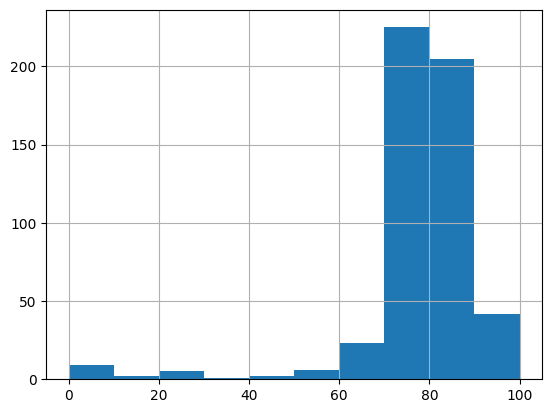

In [3]:
df_popular['popularity_metric'].hist()
plt.show()

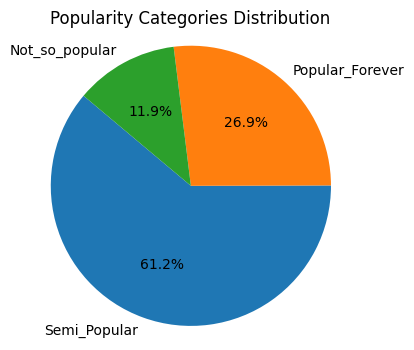

In [10]:
# Define the bin edges for the categories based on the provided ranges
bins = [-np.inf, 70, 83, np.inf]
labels = ['Not_so_popular', 'Semi_Popular', 'Popular_Forever']

# Create a new categorical column
df_popular['popularity_category'] = pd.cut(df_popular['popularity_metric'], bins=bins, labels=labels)

# Group the data by the popularity categories and count the occurrences in each category
category_counts = df_popular['popularity_category'].value_counts()

# Create a pie chart
plt.figure(figsize=(4, 4))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Popularity Categories Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

In [11]:
df_sp_predict = df_spotify.merge(df_popular[['track_name', 'popularity_metric','popularity_category']], 
                       on='track_name', 
                       how='left')

df_sp_predict.head(2)

,track_name,artist_name,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year,genres,loudness_scaled,popularity_metric,popularity_category
0,Blinding Lights,The Weeknd,0.514,0.730,Key_1,major,0.0598,0.00146,0.000095,0.0897,0.334,171.005,4,2020,"Pop,Jazz",0.787488,91.0,Popular_Forever
1,Dance Monkey,Tones And I,0.824,0.587,Key_6,minor,0.0937,0.69000,0.000105,0.1490,0.514,98.029,4,2021,Pop,0.756571,78.0,Semi_Popular


In [12]:
print(df_sp_predict.shape)
df_sp_predict.dropna()
print(df_sp_predict.shape)

(532, 18)
(532, 18)


In [13]:
duplicate_tracks = df_sp_predict[df_sp_predict['track_name'].duplicated(keep='first')]

#### Remove duplicates based on the "track_name" column
df_sp_clean = df_sp_predict.drop_duplicates(subset=['track_name'], keep='first')
print(df_sp_clean.shape)

(517, 18)


In [27]:
nan_mask = df_sp_clean.isna().any(axis=1)

df_sp_clean[nan_mask].shape


(30, 18)

In [28]:
df_sp_clean = df_sp_clean.dropna()
print(df_sp_clean.shape)

(487, 18)


In [29]:
#### Scaling only the tempo, since rest of the values are between 0 and 1

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
feature_to_scale = 'tempo'
df_sp_clean[[feature_to_scale]] = scaler.fit_transform(df_sp_clean[[feature_to_scale]])


In [30]:
df_sp_clean.head(2)

,track_name,artist_name,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year,genres,loudness_scaled,popularity_metric,popularity_category
0,Blinding Lights,The Weeknd,0.514,0.730,Key_1,major,0.0598,0.00146,0.000095,0.0897,0.334,0.773783,4,2020,"Pop,Jazz",0.787488,91.0,Popular_Forever
1,Dance Monkey,Tones And I,0.824,0.587,Key_6,minor,0.0937,0.69000,0.000105,0.1490,0.514,0.241427,4,2021,Pop,0.756571,78.0,Semi_Popular


Currently not encoding the key and mode of the dataset.

In [31]:
#### Next take only the numerical features as X and y1 as categorical feature and y2 as numerical popularity

X = df_sp_clean[['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence','tempo','time_signature','loudness_scaled']]
y_cont = df_sp_clean['popularity_metric']
y_class = df_sp_clean['popularity_category']


First let us try classification models

Staring with the baseline which I am choosing Logistic Regression

In [35]:
### SPLITTING THE DATASET
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y_class, test_size=0.3, random_state=42, stratify=y_class)

In [37]:
################################################### LOGISTIC REGRESSION ######################################################
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)  # Increased max_iter for convergence

# Fit the model on the training data
log_reg.fit(X_train1, y_train1)

# Predict on the test data
y_pred_lr = log_reg.predict(X_test1)

# Evaluate the model
accuracy = accuracy_score(y_test1, y_pred_lr)
report = classification_report(y_test1, y_pred_lr)
confusion = confusion_matrix(y_test1, y_pred_lr)

# Print the evaluation results
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


Accuracy: 0.6462585034013606
Classification Report:
                 precision    recall  f1-score   support

 Not_so_popular       0.00      0.00      0.00        19
Popular_Forever       1.00      0.03      0.06        34
   Semi_Popular       0.64      1.00      0.78        94

       accuracy                           0.65       147
      macro avg       0.55      0.34      0.28       147
   weighted avg       0.64      0.65      0.51       147



c:\Users\megha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\megha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\megha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

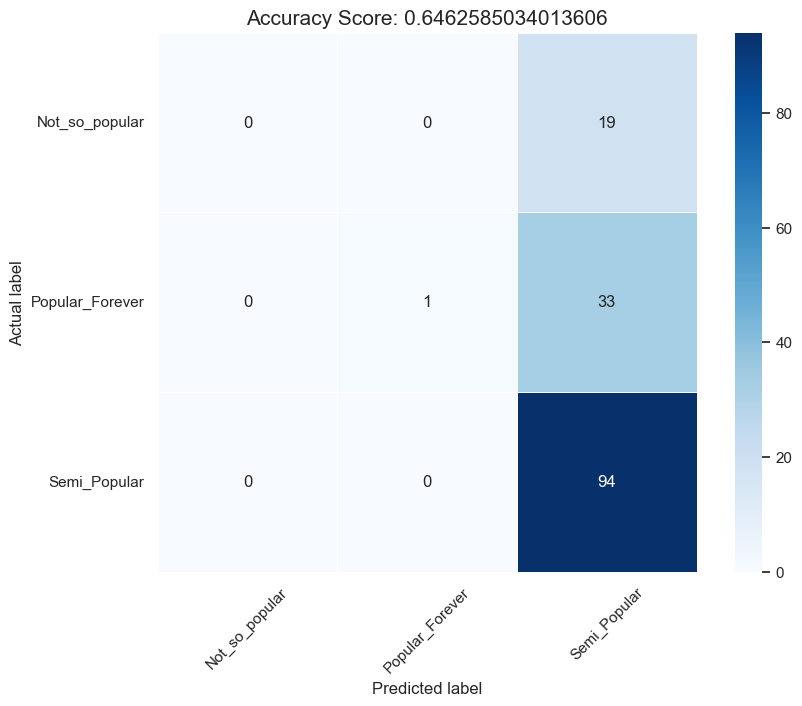

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your confusion matrix is named 'confusion' as per your code
sns.set(color_codes=True)

# Create a heatmap for the confusion matrix
plt.figure(1, figsize=(10, 7))
sns.heatmap(confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues')

# Add labels to the plot
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Title can be the overall accuracy
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15)

# Add tick labels
class_names = ['Not_so_popular', 'Popular_Forever', 'Semi_Popular'] # adjust based on your target names
tick_marks = np.arange(len(class_names)) + 0.5
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names, rotation=0)

# Display the confusion matrix
plt.show()

Because we have so less data for Popular Forever and Not_So_Popular songs, I have an idea about taking some more songs from that Category and seeing of the model will actually work or not

In [112]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

# Set up Spotipy with your Spotify API credentials
client_id = 'XXXXXX'
client_secret = 'XXXXXX'

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

def get_track_features(track_id):
    # Fetch track features and return them
    audio_features = sp.audio_features(track_id)[0]
    return [
        audio_features['danceability'],
        audio_features['energy'],
        audio_features['speechiness'],
        audio_features['acousticness'],
        audio_features['instrumentalness'],
        audio_features['liveness'],
        audio_features['valence'],
        audio_features['tempo'],
        audio_features['time_signature'],
        audio_features['loudness']
    ]

def get_track_data(track_id):
    # Fetch track details
    track = sp.track(track_id)
    artist = sp.artist(track['artists'][0]['id'])
    track_features = get_track_features(track_id)
    return [
        track['name'],
        artist['genres'],
        track['album']['release_date'],
        track['artists'][0]['name'],
        track['popularity'],
    ] + track_features

def get_tracks_from_playlists(playlist_ids, additional_track_ids=[]):
    tracks = []

    for playlist_id in playlist_ids:
        # Fetch tracks from the playlist
        results = sp.playlist_tracks(playlist_id)
        for item in results['items']:
            track = item['track']
            if track is not None:  # Make sure track details are present
                tracks.append(get_track_data(track['id']))

    for track_id in additional_track_ids:
        tracks.append(get_track_data(track_id))

    columns = [
        'track_name', 'genre', 'release_date', 'artist_name', 'popularity_metric',
        'danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness',
        'liveness', 'valence', 'tempo', 'time_signature', 'loudness_scaled'
    ]
    return pd.DataFrame(tracks, columns=columns)

# List of playlist IDs
playlist_ids = ['37i9dQZF1DWWEJlAGA9gs0', '0VDzAG69Pyc2aHHolBoGJ6', '0ZTLxDuJEnw0NG8LgNf0PF']
# Extracted track IDs from the URLs provided
additional_track_ids = [
    "5R1a0XN84btO27Bn5uV5BK",
    "6QtneGSuw09emsTPdFV8L4",
    "0S8ibKBl3tjRmYbZhGHNhG",
    "391kBVgWlD59gWONz2IRWF",
    "7xeh81c3bxTgqUgy2WN56u",
    "4W2C1CBjOyq0BV5nwyu4cr",
    "7lUJsJkhBIUbu1LxpJ93rN",
    "6YdUxmM0KSafrcg1T6eO3Q",
    "4XdfccQYtes96uq220tsq2",
    "6dG7Ij5jxGA83OkS7bMyel",
    "2WfY2W1dGfBa6oAFQyGrI5",
    "46LFQQGf0KavPAaepNN8sB",
    "4sebUbjqbcgDSwG6PbSGI0",
    "2QXB9GugNcZqXrDXYowISU",
    "4oKf0G986QhGLG8I9dpqP0",
    "5W6KeokNeUXozE9asPqqT3",
    "2aWxDsPrW9boRYyWLF6sst",
    "1kckplL6l0nCdolLQPuFHF",
    "6A7yEXw8fIKcgx7F0EesMc",
    "7wv5ybUzYXGhig5gVBxpXS",
    "0OUrmJGCKjg7NQ0FMDkste",
    "183FkJmWrlnBUqgYv4Xzai",
    "5ZyeUQe55N3FdUCs1sOuW3",
    "4czopM9AcLjrH4IunzRoBg"
]


# Fetch tracks and their features
tracks_df = get_tracks_from_playlists(playlist_ids, additional_track_ids)
tracks_df.head(2)


,track_name,genre,release_date,artist_name,popularity_metric,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,loudness_scaled
0,"Cello Suite No. 1 in G Major, BWV 1007: I. Pré...","[baroque, classical, early music, german baroque]",1983,Johann Sebastian Bach,67,0.257,0.109,0.0597,0.900,0.867,0.0762,0.307,75.02,4,-21.356
1,"The Well-Tempered Clavier, Book 1, BWV 846-869...","[baroque, classical, early music, german baroque]",2019-03-29,Johann Sebastian Bach,65,0.221,0.126,0.0447,0.989,0.897,0.1020,0.216,133.63,4,-25.427


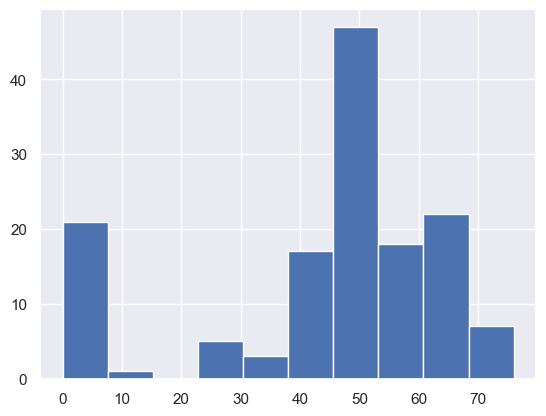

In [113]:
tracks_df['popularity_metric'].hist()
plt.show()

In [114]:
tracks_df = tracks_df[~tracks_df['popularity_metric'].between(70, 83)]

In [115]:
###### CLean this dataset to match with the cleaned dataset you allready have

# Get only the release year
tracks_df['release_year'] = pd.to_datetime(tracks_df['release_date']).dt.year

# Bin to make categories
bins = [-np.inf, 70, 83, np.inf]
labels = ['Not_so_popular', 'Semi_Popular', 'Popular_Forever']
tracks_df['popularity_category'] = pd.cut(tracks_df['popularity_metric'], bins=bins, labels=labels)

In [116]:
# Define your genre mappings
genre_map = {
    'Hardcore': ['american grindcore','ragga jungle'],
    'Hip Hop': ['hip hop', 'alt z', 'edm','brostep'],
    'Pop': ['pop','gen z'],
    'Rock': ['rock','indie','art pop','hard rock','folk-pop','italian pop'],
    'Rap': ['rap', 'chileno'],
    'Classical': ['classical','classical cello'],
    'Country': ['country','pop soul','new romantic'],
    'Latino': ['latino', 'colombiano', 'columbian', 'latin', 'corridos tumbados', 'chileno','urbano latino'],
    'Jazz' : ['r&b', 'soul']
}

# Function to map genre strings to broad categories
def map_genres(genre_string, genre_map):
    broad_genres = set()
    for genre, keywords in genre_map.items():
        if any(keyword in genre_string for keyword in keywords):
            broad_genres.add(genre)
    return list(broad_genres)

# Apply the function to your DataFrame
tracks_df['Broad_Genres'] = tracks_df['genre'].apply(lambda x: map_genres(x, genre_map))
tracks_df.head(2)

,track_name,genre,release_date,artist_name,popularity_metric,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,loudness_scaled,release_year,popularity_category,Broad_Genres
0,"Cello Suite No. 1 in G Major, BWV 1007: I. Pré...","[baroque, classical, early music, german baroque]",1983,Johann Sebastian Bach,67,0.257,0.109,0.0597,0.900,0.867,0.0762,0.307,75.02,4,-21.356,1983,Not_so_popular,[Classical]
1,"The Well-Tempered Clavier, Book 1, BWV 846-869...","[baroque, classical, early music, german baroque]",2019-03-29,Johann Sebastian Bach,65,0.221,0.126,0.0447,0.989,0.897,0.1020,0.216,133.63,4,-25.427,2019,Not_so_popular,[Classical]


In [118]:
empty_genre_df = tracks_df[tracks_df['Broad_Genres'] == '[]']
# Display the empty genre rows
empty_genre_df

,track_name,genre,release_date,artist_name,popularity_metric,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,loudness_scaled,release_year,popularity_category,Broad_Genres


In [119]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
tracks_df['loudness_scaled'] = scaler.fit_transform(tracks_df[['loudness_scaled']])

tracks_df.head(2)

,track_name,genre,release_date,artist_name,popularity_metric,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,loudness_scaled,release_year,popularity_category,Broad_Genres
0,"Cello Suite No. 1 in G Major, BWV 1007: I. Pré...","[baroque, classical, early music, german baroque]",1983,Johann Sebastian Bach,67,0.257,0.109,0.0597,0.900,0.867,0.0762,0.307,75.02,4,0.528779,1983,Not_so_popular,[Classical]
1,"The Well-Tempered Clavier, Book 1, BWV 846-869...","[baroque, classical, early music, german baroque]",2019-03-29,Johann Sebastian Bach,65,0.221,0.126,0.0447,0.989,0.897,0.1020,0.216,133.63,4,0.425692,2019,Not_so_popular,[Classical]


In [120]:
tracks_df['track_name'] = tracks_df['track_name'].str.replace(r'[^A-Za-z0-9\s\-_]', '')
tracks_df = tracks_df.drop(['release_date','genre'], axis=1)

C:\Users\megha\AppData\Local\Temp\ipykernel_25820\2725573547.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  tracks_df['track_name'] = tracks_df['track_name'].str.replace(r'[^A-Za-z0-9\s\-_]', '')


In [101]:
df_sp_clean = df_sp_clean.drop(['key','mode'], axis=1)

In [121]:
tracks_df = tracks_df.rename(columns={'Broad_Genres': 'genres'})

In [122]:
feature_to_scale = 'tempo'
tracks_df[[feature_to_scale]] = scaler.fit_transform(tracks_df[[feature_to_scale]])
tracks_df.head(2)

,track_name,artist_name,popularity_metric,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,loudness_scaled,release_year,popularity_category,genres
0,Cello Suite No 1 in G Major BWV 1007 I Prlude,Johann Sebastian Bach,67,0.257,0.109,0.0597,0.900,0.867,0.0762,0.307,0.404033,4,0.528779,1983,Not_so_popular,[Classical]
1,The Well-Tempered Clavier Book 1 BWV 846-869 ...,Johann Sebastian Bach,65,0.221,0.126,0.0447,0.989,0.897,0.1020,0.216,0.719687,4,0.425692,2019,Not_so_popular,[Classical]


In [123]:
# Assuming your two dataframes are named df1 and df2
# spotify_final = pd.concat([df_sp_clean, tracks_df], ignore_index=True)
df = pd.concat([spotify_final, tracks_df], ignore_index=True)


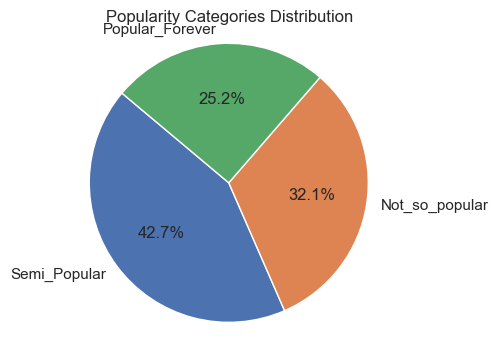

In [124]:
# Group the data by the popularity categories and count the occurrences in each category
category_counts = df['popularity_category'].value_counts()

# Create a pie chart
plt.figure(figsize=(4, 4))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Popularity Categories Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

In [125]:
#### NOW LET US RUN THE MODEL AND SEE

#### Next take only the numerical features as X and y1 as categorical feature and y2 as numerical popularity

X = df[['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence','tempo','time_signature','loudness_scaled']]
y_cont = df['popularity_metric']
y_class = df['popularity_category']


In [127]:
### SPLITTING THE DATASET
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y_class, test_size=0.3, random_state=42, stratify=y_class)

In [134]:
################################################### LOGISTIC REGRESSION ######################################################
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

log_reg = LogisticRegression(max_iter=1000)  

log_reg.fit(X_train1, y_train1)

y_pred_lr = log_reg.predict(X_test1)

# Evaluate the model
accuracy = accuracy_score(y_test1, y_pred_lr)
report = classification_report(y_test1, y_pred_lr)
confusion = confusion_matrix(y_test1, y_pred_lr)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


Accuracy: 0.634703196347032
Classification Report:
                 precision    recall  f1-score   support

 Not_so_popular       0.90      0.66      0.76        70
Popular_Forever       0.44      0.07      0.12        55
   Semi_Popular       0.56      0.95      0.70        94

       accuracy                           0.63       219
      macro avg       0.64      0.56      0.53       219
   weighted avg       0.64      0.63      0.58       219



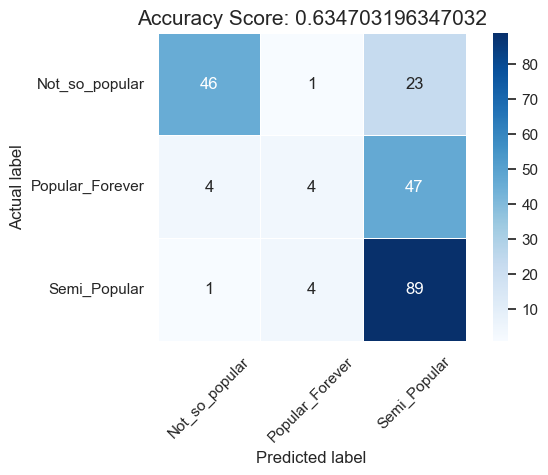

In [135]:
sns.set(color_codes=True)

plt.figure(1, figsize=(7, 4))
sns.heatmap(confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')

all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15)

class_names = ['Not_so_popular', 'Popular_Forever', 'Semi_Popular'] 
tick_marks = np.arange(len(class_names)) + 0.5
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names, rotation=0)

plt.show()

In [141]:
##################################### Random Forest #########################################

from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)  

rf_classifier.fit(X_train1, y_train1)  

y_pred_rf = rf_classifier.predict(X_test1)  

# Evaluate the model
accuracy = accuracy_score(y_test1, y_pred_rf)
report = classification_report(y_test1, y_pred_rf)
confusion = confusion_matrix(y_test1, y_pred_rf)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


Accuracy: 0.6621004566210046
Classification Report:
                 precision    recall  f1-score   support

 Not_so_popular       0.87      0.64      0.74        70
Popular_Forever       0.52      0.40      0.45        55
   Semi_Popular       0.62      0.83      0.71        94

       accuracy                           0.66       219
      macro avg       0.67      0.62      0.63       219
   weighted avg       0.68      0.66      0.66       219



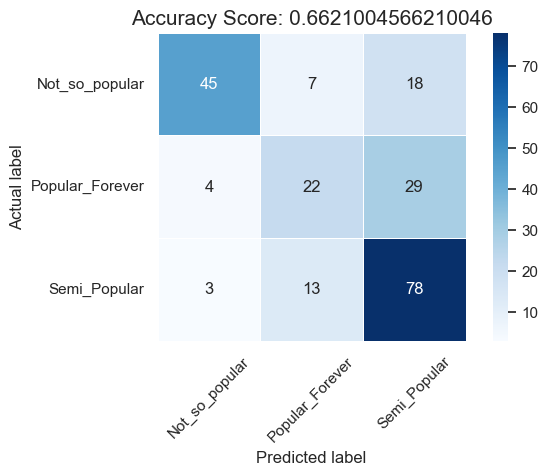

In [142]:
sns.set(color_codes=True)

# Create a heatmap for the confusion matrix
plt.figure(1, figsize=(7, 4))
sns.heatmap(confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')

all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15)

class_names = ['Not_so_popular', 'Popular_Forever', 'Semi_Popular']
tick_marks = np.arange(len(class_names)) + 0.5
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names, rotation=0)

plt.show()

In [138]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train1, y_train1)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test1)


In [143]:
accuracy = accuracy_score(y_test1, y_pred)
report = classification_report(y_test1, y_pred)
confusion = confusion_matrix(y_test1, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.680365296803653
Classification Report:
                 precision    recall  f1-score   support

 Not_so_popular       0.86      0.63      0.73        70
Popular_Forever       0.56      0.40      0.47        55
   Semi_Popular       0.64      0.88      0.74        94

       accuracy                           0.68       219
      macro avg       0.69      0.64      0.65       219
   weighted avg       0.69      0.68      0.67       219



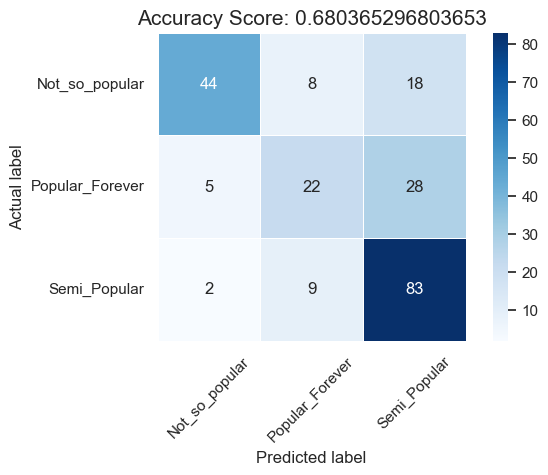

In [144]:
sns.set(color_codes=True)

# Create a heatmap for the confusion matrix
plt.figure(1, figsize=(7, 4))
sns.heatmap(confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')

all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15)

class_names = ['Not_so_popular', 'Popular_Forever', 'Semi_Popular']
tick_marks = np.arange(len(class_names)) + 0.5
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names, rotation=0)

plt.show()

Accuracy: 0.6301369863013698
Classification Report:
                 precision    recall  f1-score   support

 Not_so_popular       0.93      0.60      0.73        70
Popular_Forever       0.75      0.05      0.10        55
   Semi_Popular       0.55      0.99      0.70        94

       accuracy                           0.63       219
      macro avg       0.74      0.55      0.51       219
   weighted avg       0.72      0.63      0.56       219



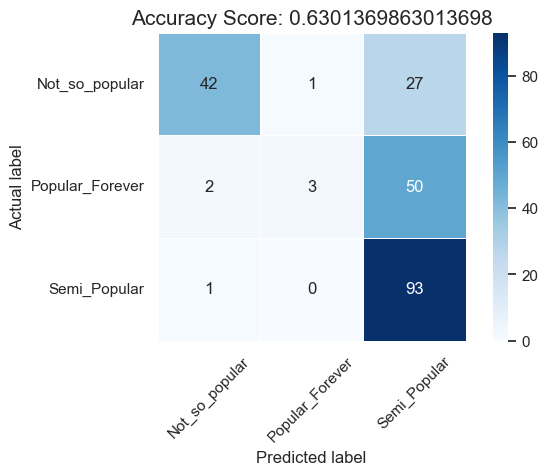

In [145]:
######################################################################### SVM ##########################################################################

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
}

svm_classifier = SVC(random_state=42)

grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train1, y_train1)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test1)

accuracy = accuracy_score(y_test1, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test1, y_pred)
print("Classification Report:")
print(report)

confusion = confusion_matrix(y_test1, y_pred)

sns.set(color_codes=True)

plt.figure(1, figsize=(7, 4))
sns.heatmap(confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')

all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15)

class_names = ['Not_so_popular', 'Popular_Forever', 'Semi_Popular']
tick_marks = np.arange(len(class_names)) + 0.5
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names, rotation=0)

plt.show()

The reason I am not proceeding with the other classification models is because the size of the dataset is so small that using Neural Networks and such will overfit the data.

In [150]:
### SPLITTING THE DATASET
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_cont, test_size=0.2, random_state=42)

In [151]:
#############################################################################3 LINEAR REGRESSION ##########################################################################################
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize the Linear Regression model
linear_reg = LinearRegression()

# Fit the model on the training data
linear_reg.fit(X_train2, y_train2)

# Predict on the test data
y_pred_linear = linear_reg.predict(X_test2)

# Evaluate the model
mse = mean_squared_error(y_test2, y_pred_linear)
rmse = mean_squared_error(y_test2, y_pred_linear, squared=False)
mae = mean_absolute_error(y_test2, y_pred_linear)
r_squared = r2_score(y_test2, y_pred_linear)

# Print the evaluation results
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared:", r_squared)


Mean Squared Error: 313.3910485604594
Root Mean Squared Error: 17.702854248975203
Mean Absolute Error: 11.950814010248491
R-squared: 0.24284493688416064


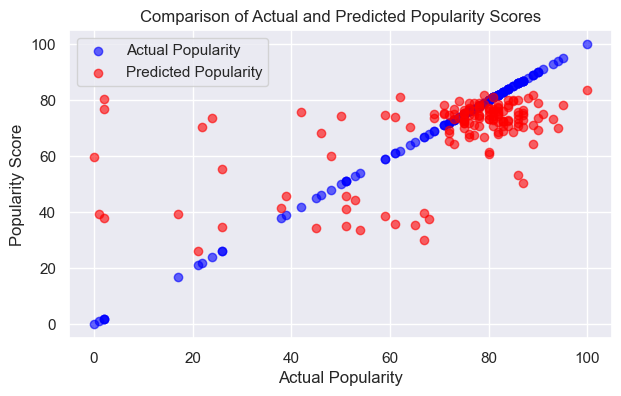

In [153]:
import matplotlib.pyplot as plt

# Scatter plot of Actual vs Predicted values with different colors
plt.figure(figsize=(7, 4))

# Plot actual values
plt.scatter(y_test2, y_test2, color='blue', alpha=0.6, label='Actual Popularity')

# Plot predicted values
plt.scatter(y_test2, y_pred_linear, color='red', alpha=0.6, label='Predicted Popularity')

# Title and labels
plt.title('Comparison of Actual and Predicted Popularity Scores')
plt.xlabel('Actual Popularity')
plt.ylabel('Popularity Score')
plt.legend()  # To add a legend to distinguish between actual and predicted values
plt.grid(True)

# Show plot
plt.show()


In [177]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_cont, test_size=0.2, random_state=42)


In [157]:
############################################################################# RANDOM FOREST REGRESSOR ###################################################################################

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [158]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

mse_scores = -cv_scores
rmse_scores = np.sqrt(mse_scores)
print(f'Cross-validated RMSE scores: {rmse_scores}')
print(f'Mean RMSE: {np.mean(rmse_scores)}')

Cross-validated RMSE scores: [21.89462142 15.8980603  19.47636277 20.48410494 15.19161932]
Mean RMSE: 18.58895374924615


In [159]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [160]:
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=300,
                      random_state=42)

In [161]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred_test = best_rf.predict(X_test)

final_mse = mean_squared_error(y_test, y_pred_test)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test, y_pred_test)

print(f'Final RMSE: {final_rmse}')
print(f'Final R-squared: {final_r2}')


Final RMSE: 18.51071882164917
Final R-squared: 0.17216304196285448


In [162]:
# feature importances
importances = best_rf.feature_importances_

feature_list = list(X.columns)
feature_importances = sorted(zip(importances, feature_list), reverse=True)
print("Feature importances:")
for importance, feature in feature_importances:
    print(f'{feature}: {importance}')


Feature importances:
instrumentalness: 0.4425365126749672
energy: 0.1200737561284358
acousticness: 0.09147823243344352
danceability: 0.06492858573157209
liveness: 0.06196783724831553
loudness_scaled: 0.06131318392597827
speechiness: 0.05840510946995419
tempo: 0.05604072813134426
valence: 0.04187597519079389
time_signature: 0.0013800790651952739


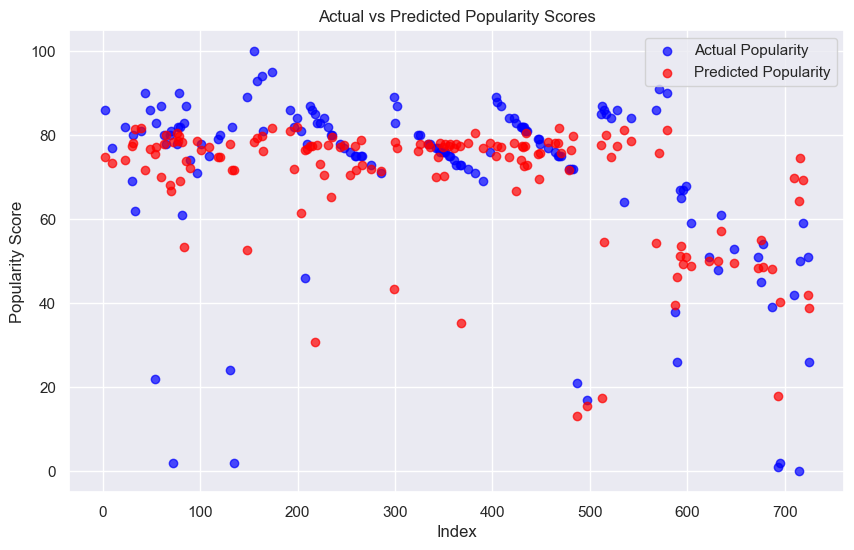

In [163]:
import matplotlib.pyplot as plt

# Scatter plot of Actual vs Predicted values
plt.figure(figsize=(10, 6))

# Actual values
plt.scatter(X_test.index, y_test, color='blue', alpha=0.7, label='Actual Popularity')

# Predicted values
plt.scatter(X_test.index, y_pred_test, color='red', alpha=0.7, label='Predicted Popularity')

# Title and labels
plt.title('Actual vs Predicted Popularity Scores')
plt.xlabel('Index')
plt.ylabel('Popularity Score')
plt.legend(loc='best')
plt.grid(True)

# Show plot
plt.show()


In [178]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define the model
gbr = GradientBoostingRegressor(random_state=42)

# Define the parameters for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup the grid search
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Get the best estimator
best_gbr = grid_search.best_estimator_

# Predict on the test data
y_pred = best_gbr.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Mean Squared Error:  336.4607386527059


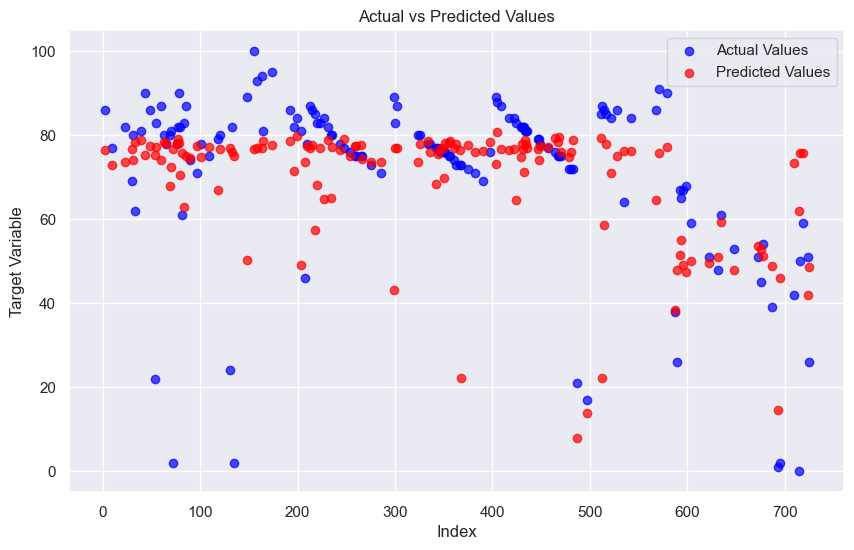

In [179]:
import matplotlib.pyplot as plt

# Make sure you've already calculated y_pred using your Gradient Boosting model
# y_pred = best_gbr.predict(X_test)

# Scatter plot of Actual vs Predicted values
plt.figure(figsize=(10, 6))

# Actual values
plt.scatter(X_test.index, y_test, color='blue', alpha=0.7, label='Actual Values')

# Predicted values from Gradient Boosting model
plt.scatter(X_test.index, y_pred, color='red', alpha=0.7, label='Predicted Values')

# Title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Target Variable')
plt.legend(loc='best')
plt.grid(True)

# Show plot
plt.show()


In [180]:
feature_importances = best_gbr.feature_importances_

feature_importance_pairs = zip(X_train.columns, feature_importances)

sorted_feature_importances = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")


instrumentalness: 0.5301476075241647
energy: 0.11529579316191715
danceability: 0.07204476508993302
acousticness: 0.0633685876524271
loudness_scaled: 0.05586101980129204
speechiness: 0.0506829373262509
tempo: 0.04598482214683208
liveness: 0.04227179748705122
valence: 0.022059238607196215
time_signature: 0.0022834312029355003


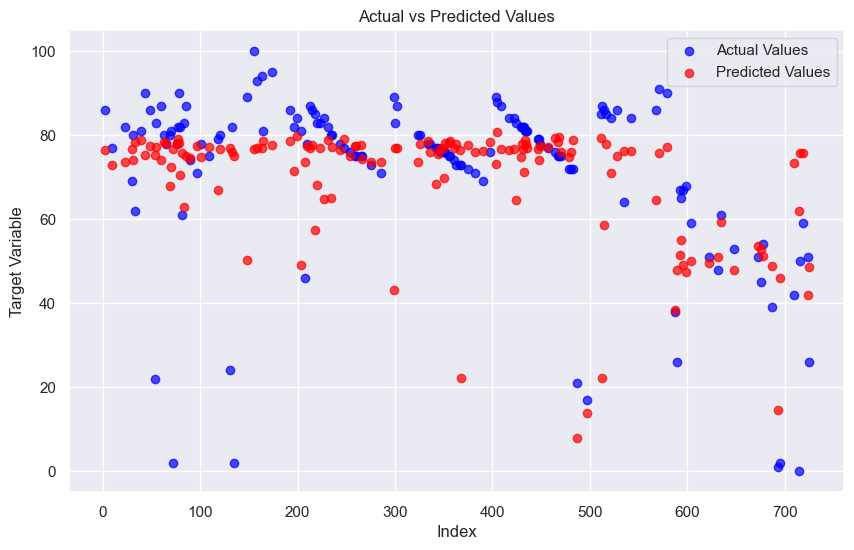

# OPTIMIZATION

Image denoted by $X \in \mathbb{R}^{28 \times 28}$

Weights denoted by $W \in \mathbb{R}^{10 \times 28 \times 28}$

The Hadamard product is given by:

$\qquad \qquad Z_c(X) = \sum_{i,j} X_{i,j}W_{c,i,j}$

The Predictions are:

$\qquad \qquad Y_c(X) = \frac{e^{Z_{c}}}{\sum_{c}e^{Z_c}}$

Cross Entropy Loss:

$\qquad \qquad CE = - \sum_c t_c log(Y_c(X))$


Objective : $\quad \underset{w}\min\text{ } CE$

Constrained on:

$\qquad \qquad F \{W_c\}[i,j] = 0 \qquad \forall |14-i| + |j-14| <= 28 - n ; \forall c$

Image: $X \in \mathbb{R}^{28 \times 28}$

Weights: $W \in \mathbb{R}^{10 \times 28 \times 28}$


$Z[k] = \underset{i}\sum \underset{j}\sum X_{i,j} W[k]_{i,j}$


$Y = Softmax(Z)$

$Y[c] = \frac{e^{Z[c]}}{\underset{k}\sum e^{Z[k]}}$

$CE = - \underset{c} \sum t_c log(Y(x)_c)$

Constraints: $F \{W[c]\}[i:n-i] = 0$



Computational Power:   PyTorch, - 10 

Slides to add : 4,5,6,
Denoised Results : 14, 11, 13
